In [1]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.insert(0, '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-a5275d8')

import torch
from modulus.datapipes.climate import ERA5HDF5Datapipe
from examples.weather.graphcast.train_utils import prepare_input

datapipe = ERA5HDF5Datapipe(
    data_dir="/iopsstor/scratch/cscs/stefschu/DSM500_FPR/data/FCN_ERA5_data_v0/lap",
    stats_dir="/iopsstor/scratch/cscs/stefschu/DSM500_FPR/data/FCN_ERA5_data_v0/stats",
    channels=list(range(0, 21)),
    latlon_resolution=(721, 1440),
    interpolation_type=None,
    num_samples_per_year=1452,
    num_steps=1,
    num_history=0,
    use_cos_zenith=True,
    use_time_of_year_index=True,
    cos_zenith_args={
        "dt": 6,
        "start_year": 1979,
    },
    batch_size=1,
    num_workers=1,
    device=torch.device('cuda', index=0),
    process_rank=0,
    world_size=1,
    shuffle=False
)

means = []
samples = 2000

for i, data in enumerate(datapipe):
    if i == samples:
        break
    invar = data[0]["invar"]
    outvar = data[0]["outvar"]
    try:
        cos_zenith = data[0]["cos_zenith"]
    except KeyError:
        cos_zenith = None
    try:
        time_idx = data[0]["time_of_year_idx"].item()
    except KeyError:
        time_idx = None

    invar_cat = prepare_input(
        invar,
        cos_zenith,
        num_history=0,
        static_data=None,
        step=1,
        time_idx=time_idx,
        stride=1,
        dt=6,
        num_samples_per_year=1952,
        device=torch.device('cuda', index=0),
    )
    invar_cat, outvar = invar_cat.to(dtype=torch.bfloat16), outvar.to(dtype=torch.bfloat16)
    
    # Get the mean for the least 4 channels, which are the ones pertaining to temporal information
    means.append(invar_cat[0, -4:].mean(dim=(1, 2)).tolist())

    print(f"{i / samples * 100:.2f}%", end="\r")

In [2]:
import numpy as np

data = np.array(means)
data.shape

(2000, 4)

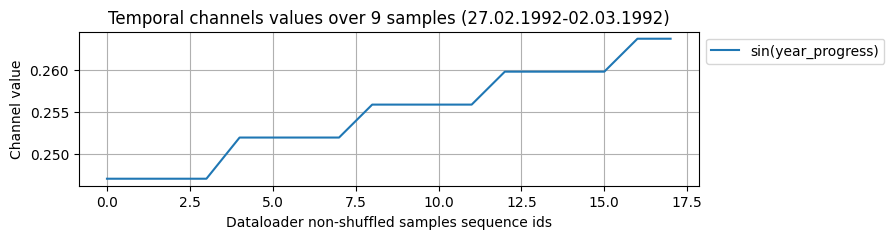

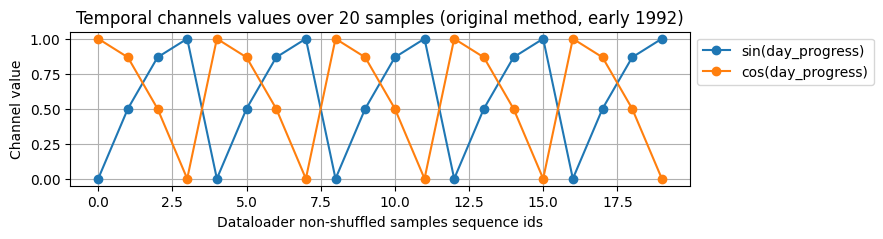

Process SpawnProcess-1:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 462, in worker
    scheduled, shm_chunk = worker_context.get_task()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 434, in get_task
    scheduled_meta = self.task_receiver.get_task()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 132, in get_task
    recv = self.queue.get()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/shared_queue.py", line 171, in get
    waited = self._wait_for_samples()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/shared_queue.py", line 99, in _wait_for_samples
    self.cv_not_e

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
plt.plot(data[232:250, 0], label=f"sin(year_progress)")
#plt.plot(data[:9, 1], label=f"cos(year_progress)")
plt.title("Temporal channels values over 9 samples (27.02.1992-02.03.1992)")
plt.xlabel("Dataloader non-shuffled samples sequence ids")
plt.ylabel("Channel value")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(data[:, 0], label=f"sin(year_progress)")
plt.plot(data[:, 1], label=f"cos(year_progress)")
plt.title("Temporal channels values over 2000 samples (improved method, years 1992-1993)")
plt.xlabel("Dataloader non-shuffled samples sequence ids")
plt.ylabel("Channel value")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(data[:20, 2], label=f"sin(day_progress)", marker="o")
plt.plot(data[:20, 3], label=f"cos(day_progress)", marker="o")
plt.title("Temporal channels values over 20 samples (original method, early 1992)")
plt.xlabel("Dataloader non-shuffled samples sequence ids")
plt.ylabel("Channel value")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline')

from modulus.utils.distributed_manager import DistributedManager as DM
from modulus.utils.caching import Cache
from omegaconf import OmegaConf
from modulus.datapipes.era5_hdf5 import ERA5HDF5Datapipe

cfg = OmegaConf.load('/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/conf/config.yaml')

# Test that the new dataloader can go back to the old method
cfg.toggles.data.fix_temporal_info = False

DM.destroy()
DM.initialize()
Cache.initialize(dir=cfg.cache.dir)

# init the model to have the field data structures
from modulus.models.graph_cast_net import GraphCastNet
model = GraphCastNet(cfg)


datapipe = ERA5HDF5Datapipe(
    cfg=cfg,
    dataset_folder='lap',
    num_output_steps=1,

    latitudes=model.latitudes,
    longitudes=model.longitudes,
    map_grid_to_latlon=model.map_grid_to_latlon,
    dtype=model.dtype(),

    iterator={
        "shuffle": False,
        "shuffle_seed": 0,
        "initial_epoch_idx": 0,
        "initial_sample_idx": 0
    }
)

means = []
samples = 2000

for i, sample in enumerate(datapipe):
    if i == samples:
        break

    epoch_idx = sample["epoch_idx"]
    idx_in_epoch = sample["idx_in_epoch"]
    global_sample_id = sample["global_sample_id"]
    data = sample["data"][0, -4:]

    means.append(data.mean(dim=(1, 2)).tolist())

    print(f"{i / samples * 100:.2f}%", end="\r")

import numpy as np

data = np.array(means)
data.shape

/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/modulus/utils/distributed_manager.py:39: UserWarning: DistributedManager: running in single process mode!
  warn("DistributedManager: running in single process mode!")


(2000, 4)

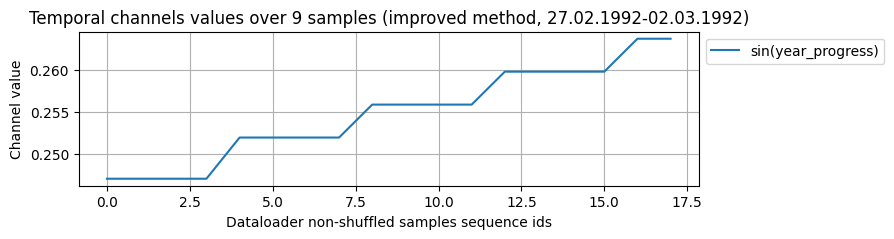

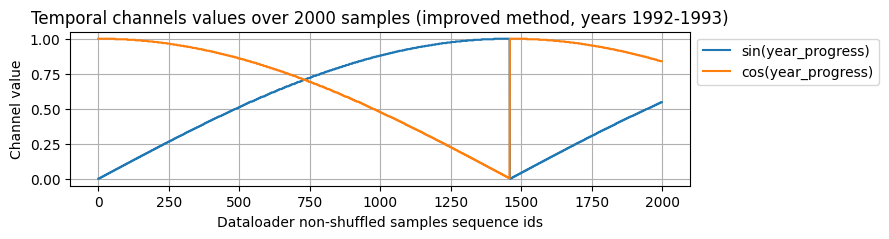

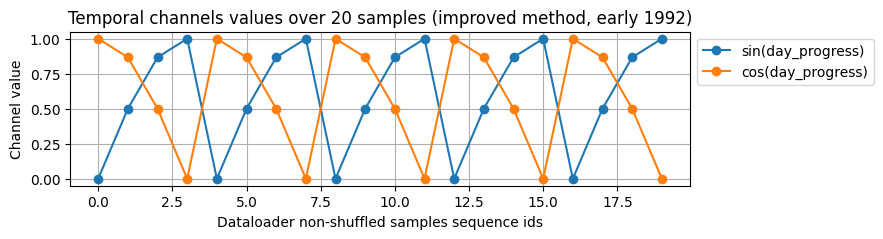

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
plt.plot(data[232:250, 0], label=f"sin(year_progress)")
#plt.plot(data[:9, 1], label=f"cos(year_progress)")
plt.title("Temporal channels values over 9 samples (improved method, 27.02.1992-02.03.1992)")
plt.xlabel("Dataloader non-shuffled samples sequence ids")
plt.ylabel("Channel value")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(data[:, 0], label=f"sin(year_progress)")
plt.plot(data[:, 1], label=f"cos(year_progress)")
plt.title("Temporal channels values over 2000 samples (improved method, years 1992-1993)")
plt.xlabel("Dataloader non-shuffled samples sequence ids")
plt.ylabel("Channel value")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()


plt.figure(figsize=(8, 2))
plt.plot(data[:20, 2], label=f"sin(day_progress)", marker="o")
plt.plot(data[:20, 3], label=f"cos(day_progress)", marker="o")
plt.title("Temporal channels values over 20 samples (improved method, early 1992)")
plt.xlabel("Dataloader non-shuffled samples sequence ids")
plt.ylabel("Channel value")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline')

from modulus.utils.distributed_manager import DistributedManager as DM
from modulus.utils.caching import Cache
from omegaconf import OmegaConf
from modulus.datapipes.era5_hdf5 import ERA5HDF5Datapipe

cfg = OmegaConf.load('/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/conf/config.yaml')

# Test that the new dataloader can go back to the old method
cfg.toggles.data.fix_temporal_info = False

DM.destroy()
DM.initialize()
Cache.initialize(dir=cfg.cache.dir)

# init the model to have the field data structures
from modulus.models.graph_cast_net import GraphCastNet
model = GraphCastNet(cfg)

/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/modulus/utils/distributed_manager.py:39: UserWarning: DistributedManager: running in single process mode!
  warn("DistributedManager: running in single process mode!")


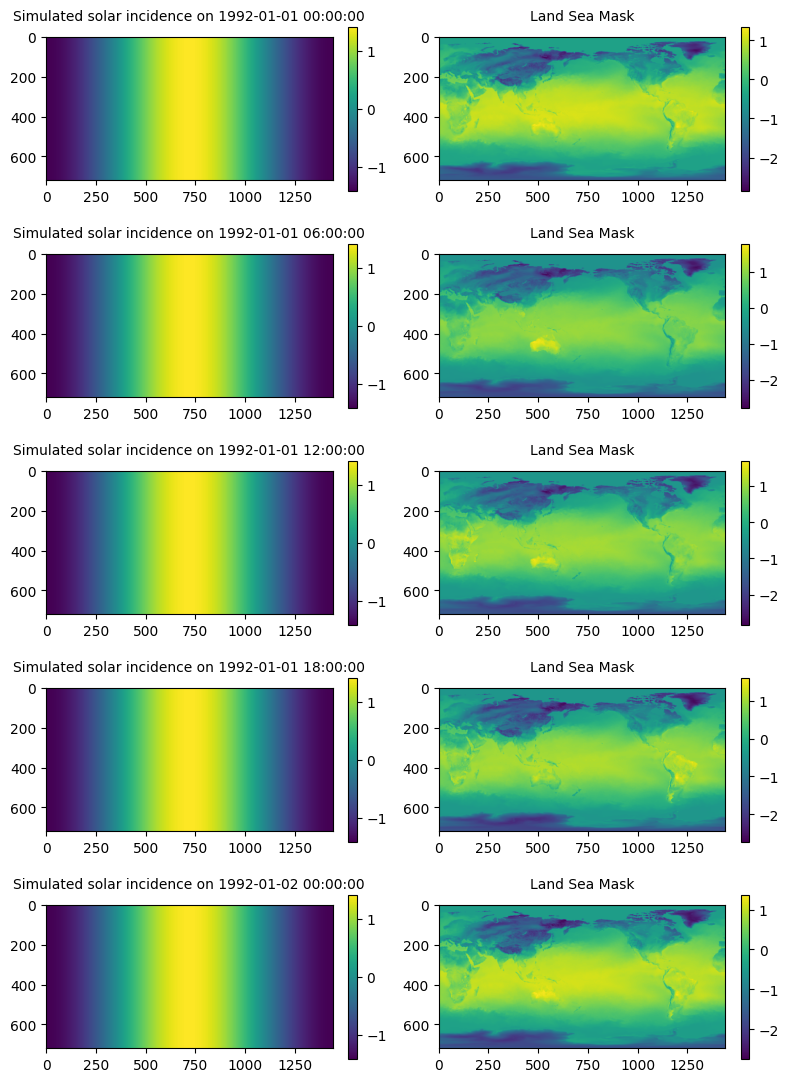

In [2]:
cfg.toggles.data.fix_data_centering = False

datapipe = ERA5HDF5Datapipe(
    cfg=cfg,
    dataset_folder='lap',
    num_output_steps=5,

    latitudes=model.latitudes,
    longitudes=model.longitudes,
    map_grid_to_latlon=model.map_grid_to_latlon,
    dtype=model.dtype(),

    iterator={
        "shuffle": False,
        "shuffle_seed": 0,
        "initial_epoch_idx": 0,
        "initial_sample_idx": 0
    }
)

sample = next(iter(datapipe))
sample.keys()

from datetime import datetime
import matplotlib.pyplot as plt
import torch

timestamps = sample["timestamps"]
data = sample["data"]

fig, axes = plt.subplots(5, 2, figsize=(8, 11))

for t in range(axes.shape[0]):
    time_label = datetime.fromtimestamp(timestamps[t]).strftime("%Y-%m-%d %H:%M:%S")
    
    im = axes[t, 0].imshow(data[t, 25, :, :].to(dtype=torch.float32).cpu().numpy())
    axes[t, 0].set_title(f"Simulated solar incidence on {time_label}", fontsize=10, pad=12)
    fig.colorbar(im, fraction=0.05, pad=0.05)
    im = axes[t, 1].imshow(data[t, 20, :, :].to(dtype=torch.float32).cpu().numpy())
    axes[t, 1].set_title(f"Land Sea Mask", fontsize=10, pad=12)
    fig.colorbar(im, fraction=0.05, pad=0.05)

plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

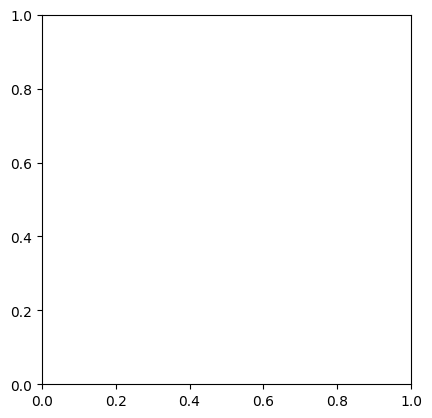

In [3]:
plt.imshow(model.area)
plt.colorbar()
plt.show()

In [5]:
from functools import partial

dataloader = partial(ERA5HDF5Datapipe,
    dataset_folder='train',
    num_output_steps=1,

    latitudes=model.latitudes,
    longitudes=model.longitudes,
    map_grid_to_latlon=model.map_grid_to_latlon,
    dtype=model.dtype(),

    iterator={
        "shuffle": False,
        "shuffle_seed": 0,
        "initial_epoch_idx": 0,
        "initial_sample_idx": 0
    }
)

cfg.toggles.data.fix_december_gap = False
datapipe_old_method = dataloader(cfg=cfg)
print(f"Dataloader training samples (old method): {len(datapipe_old_method)}")

cfg.toggles.data.fix_december_gap = True
datapipe_new_method = dataloader(cfg=cfg)
print(f"Dataloader training samples (new method): {len(datapipe_new_method)}")

Dataloader training samples (old method): 53946
Dataloader training samples (new method): 54018
